In [8]:
## PARTE II — Reordenação dos passos e uso de Pipeline

## Nesta parte, vamos:
## 1. Usar o mesmo dataset da Parte I (CS:GO Round Winner).
## 2. Reorganizar a ordem dos passos (dividir antes de preparar os dados).
## 3. Criar um **pipeline** com:
   ## - Preparação dos dados
   ## - Treinamento do modelo (RandomForestClassifier)
## 4. Avaliar o modelo com duas métricas e escrever conclusões finais.


In [9]:
# PARTE II - Versão 1: reordenando os passos

from pathlib import Path
import pandas as pd
import numpy as np

# (Parte II): Carregar novamente o dataset
DATA_PATH = Path("/content/csgo_round_snapshots.xlsx")

assert DATA_PATH.exists(),

df2 = pd.read_excel(DATA_PATH)

# Normalizei nomes de colunas
df2.columns = (
    df2.columns
      .str.strip()
      .str.replace(r"\s+", "_", regex=True)
      .str.lower()
)

print("Formato do dataframe (Parte II):", df2.shape)
print("Algumas colunas:", df2.columns.tolist()[:15])

df2.head(3)


Formato do dataframe (Parte II): (122410, 94)
Algumas colunas: ['time_left', 'ct_score', 't_score', 'map', 'ct_health', 't_health', 'ct_money', 't_money', 'ct_helmets', 't_helmets', 'ct_defuse_kits', 'ct_players_alive', 't_players_alive', 'ct_weapon_ak47', 't_weapon_ak47']


,time_left,ct_score,t_score,map,ct_health,t_health,ct_money,t_money,ct_helmets,t_helmets,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0,0,de_dust2,500,500,4000,4000,0,0,...,0,0,0,0,0,0,0,0,0,CT
1,156.03,0,0,de_dust2,500,500,600,650,0,0,...,0,0,2,0,0,0,0,0,0,CT
2,96.03,0,0,de_dust2,391,400,750,500,0,0,...,0,0,2,0,0,0,0,0,0,CT


In [10]:
# (Parte II): Definir X (features) e y (alvo) e dividir em treino/teste

import numpy as np
from sklearn.model_selection import train_test_split

# Garantir que a coluna 'round_winner' existe
assert 'round_winner' in df2.columns, "Coluna 'round_winner' não encontrada em df2."

# Mapear rótulos de texto para 0/1 (igual à Parte I)
rw2 = df2['round_winner'].astype(str).str.strip().str.lower()

label_map = {
    'ct': 0, 'counter-terrorists': 0, 'counter_terrorists': 0, 'counterterrorists': 0,
    't': 1, 'terrorists': 1
}

y2 = rw2.map(label_map)

# Verificar se ficou algum valor sem mapeamento
if y2.isna().any():
    print("Valores únicos de round_winner:", sorted(rw2.unique()))
    raise ValueError("Há valores de 'round_winner' não mapeados. Ajuste o label_map.")

# X2: todas as colunas exceto o alvo
X2 = df2.drop(columns=['round_winner'])

# Remover colunas CONSTANTES (sem variação)
const_cols2 = [c for c in X2.columns if X2[c].nunique(dropna=False) <= 1]
if const_cols2:
    X2 = X2.drop(columns=const_cols2)

print("Formato X2 / y2:", X2.shape, y2.shape)
print("Colunas constantes removidas:", const_cols2 if const_cols2 else "nenhuma")

# Divisão treino / teste (25% teste, estratificado)
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.25, stratify=y2, random_state=42
)

print("Shapes treino/teste:", X2_train.shape, X2_test.shape)
print("Proporção treino:", y2_train.value_counts(normalize=True).round(3).to_dict())
print("Proporção teste :", y2_test.value_counts(normalize=True).round(3).to_dict())


Formato X2 / y2: (122410, 87) (122410,)
Colunas constantes removidas: ['ct_weapon_bizon', 'ct_weapon_g3sg1', 't_weapon_m249', 'ct_weapon_negev', 'ct_weapon_r8revolver', 'ct_weapon_sawedoff']
Shapes treino/teste: (91807, 87) (30603, 87)
Proporção treino: {1: 0.51, 0: 0.49}
Proporção teste : {1: 0.51, 0: 0.49}


In [11]:
# (Parte II): Preparar os dados APÓS a divisão treino/teste

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Identificar tipos de variáveis usando SOMENTE o conjunto de treino
numeric_features2 = X2_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features2 = X2_train.select_dtypes(exclude=[np.number]).columns.tolist()

print("Qtd numéricas (treino):", len(numeric_features2))
print("Qtd categóricas (treino):", len(categorical_features2))
print("Algumas categóricas:", categorical_features2[:10])

# Transformação para numéricas: imputar mediana
numeric_transformer2 = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

# Transformação para categóricas: imputar valor mais frequente + OneHotEncoder
categorical_transformer2 = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

# Pré-processador geral (ColumnTransformer)
preprocessor2 = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer2, numeric_features2),
        ("cat", categorical_transformer2, categorical_features2),
    ],
    remainder="drop"
)

# Ajustar nos dados de treino e transformar treino e teste
X2_train_prepared = preprocessor2.fit_transform(X2_train)
X2_test_prepared = preprocessor2.transform(X2_test)

print("Shape X2_train_prepared:", X2_train_prepared.shape)
print("Shape X2_test_prepared :", X2_test_prepared.shape)


Qtd numéricas (treino): 86
Qtd categóricas (treino): 1
Algumas categóricas: ['map']
Shape X2_train_prepared: (91807, 94)
Shape X2_test_prepared : (30603, 94)


In [12]:
#(Parte II): Treinar o modelo e fazer predições (sem pipeline)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Mesmo tipo de modelo da Parte I: RandomForestClassifier
rf2 = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

# Treinamento
rf2.fit(X2_train_prepared, y2_train)

# Predições na base de teste
y2_pred = rf2.predict(X2_test_prepared)

print("Quantidade de previsões geradas:", len(y2_pred))
print("Acurácia simples na base de teste:", accuracy_score(y2_test, y2_pred))

# Mostrar as 10 primeiras linhas com verdadeiro x previsto
preds_preview = pd.DataFrame({
    "y_teste_verdadeiro": y2_test.iloc[:10].values,
    "y_predito": y2_pred[:10]
})
preds_preview


Quantidade de previsões geradas: 30603
Acurácia simples na base de teste: 0.8793909093879685


,y_teste_verdadeiro,y_predito
0,1,0
1,1,1
2,0,0
3,0,0
4,1,1
5,1,1
6,0,0
7,0,0
8,1,1
9,0,0


In [ ]:
### Versão 2: modelo com Pipeline (pré-processamento + RandomForest)

###Nesta versão, vamos:
###1. Utilizar o mesmo dataset e a mesma divisão em treino e teste.
###2. Criar um **Pipeline** que:
   ###- faz o pré-processamento dos dados (numéricos e categóricos),
   ###- treina o modelo `RandomForestClassifier`.
###3. Usar o pipeline para gerar as predições na base de teste.
###4. Avaliar o desempenho do pipeline com duas métricas.


In [13]:
# Versão 2 (Parte II): Pipeline = pré-processamento + RandomForest

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Usar as mesmas listas de colunas da Parte II
numeric_features_pipe = X2_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features_pipe = X2_train.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numéricas no pipeline:", len(numeric_features_pipe))
print("Categóricas no pipeline:", len(categorical_features_pipe))

# Transformação para numéricas
numeric_transformer_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

# Transformação para categóricas
categorical_transformer_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

# Pré-processador geral
preprocessor_pipe = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_pipe, numeric_features_pipe),
        ("cat", categorical_transformer_pipe, categorical_features_pipe),
    ],
    remainder="drop"
)

# Modelo
rf_model_pipe = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

# Pipeline completo
pipe2 = Pipeline(steps=[
    ("preprocess", preprocessor_pipe),
    ("model", rf_model_pipe),
])

# Treinar o pipeline
pipe2.fit(X2_train, y2_train)

# Predições na base de teste com o pipeline
y2_pred_pipe = pipe2.predict(X2_test)

print("Qtd previsões (pipeline):", len(y2_pred_pipe))
print("Acurácia (pipeline) na base de teste:", accuracy_score(y2_test, y2_pred_pipe))

# Pré-visualização das 10 primeiras linhas
preds_preview_pipe = pd.DataFrame({
    "y_teste_verdadeiro": y2_test.iloc[:10].values,
    "y_predito_pipeline": y2_pred_pipe[:10]
})
preds_preview_pipe


Numéricas no pipeline: 86
Categóricas no pipeline: 1
Qtd previsões (pipeline): 30603
Acurácia (pipeline) na base de teste: 0.8793909093879685


,y_teste_verdadeiro,y_predito_pipeline
0,1,0
1,1,1
2,0,0
3,0,0
4,1,1
5,1,1
6,0,0
7,0,0
8,1,1
9,0,0


In [14]:
# (Parte II): Avaliar o pipeline com métricas de classificação

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score,
    balanced_accuracy_score
)

# Matriz de confusão
cm = confusion_matrix(y2_test, y2_pred_pipe)

cm_df = pd.DataFrame(
    cm,
    index=["Real 0 (CT)", "Real 1 (T)"],
    columns=["Pred 0 (CT)", "Pred 1 (T)"]
)

print("Matriz de confusão:")
cm_df


Matriz de confusão:


,Pred 0 (CT),Pred 1 (T)
Real 0 (CT),13346,1655
Real 1 (T),2036,13566


from matplotlib import pyplot as plt
cm_df['Pred 0 (CT)'].plot(kind='hist', bins=20, title='Pred 0 (CT)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cm_df['Pred 1 (T)'].plot(kind='hist', bins=20, title='Pred 1 (T)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cm_df.plot(kind='scatter', x='Pred 0 (CT)', y='Pred 1 (T)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Pred 1 (T)']
  ys = series['Pred 0 (CT)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = cm_df.sort_values('Pred 1 (T)', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Pred 1 (T)')
_ = plt.ylabel('Pred 0 (CT)')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Pred 1 (T)']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Pred 1 (T)'}, axis=1)
              .sort_values('Pred 1 (T)', ascending=True))
  xs = counted['Pred 1 (T)']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = cm_df.sort_values('Pred 1 (T)', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Pred 1 (T)')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
cm_df['Pred 0 (CT)'].plot(kind='line', figsize=(8, 4), title='Pred 0 (CT)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
cm_df['Pred 1 (T)'].plot(kind='line', figsize=(8, 4), title='Pred 1 (T)')
plt.gca().spines[['top', 'right']].set_visible(False)

In [15]:
# Cálculo das duas métricas escolhidas

f1 = f1_score(y2_test, y2_pred_pipe)
bal_acc = balanced_accuracy_score(y2_test, y2_pred_pipe)

print(f"F1-score (classe 1 - T): {f1:.4f}")
print(f"Balanced accuracy        : {bal_acc:.4f}")


F1-score (classe 1 - T): 0.8803
Balanced accuracy        : 0.8796


In [16]:
# Relatório de classificação completo

print(classification_report(y2_test, y2_pred_pipe, target_names=["CT", "T"]))


              precision    recall  f1-score   support

          CT       0.87      0.89      0.88     15001
           T       0.89      0.87      0.88     15602

    accuracy                           0.88     30603
   macro avg       0.88      0.88      0.88     30603
weighted avg       0.88      0.88      0.88     30603



### Conclusões sobre o desempenho do modelo

Nesta base de dados, o objetivo era prever qual equipe venceria o round (CT ou T) a partir das informações disponíveis de cada rodada. Utilizando um modelo `RandomForestClassifier` dentro de um pipeline de pré-processamento, obtivemos os seguintes resultados na base de teste:

- **F1-score (classe T)**: 0,8803  
- **Balanced accuracy**: 0,8796  

Esses valores estão bem acima de 0,5 (que seria próximo de um chute) e relativamente próximos de 1,0. Isso indica que o modelo consegue distinguir bem as duas classes, mantendo um equilíbrio entre acertos para CT e para T. A balanced accuracy próxima do F1 mostra que o desempenho não é bom apenas para a classe mais frequente, mas também para a outra classe.

Apesar disso, ainda existem erros na matriz de confusão (falsos positivos e falsos negativos). Em um cenário real, isso poderia significar prever vitória de uma equipe quando, na prática, a outra vence, o que pode impactar decisões estratégicas.

Para melhorar esse desempenho, a equipe poderia:
- testar outros algoritmos (por exemplo, Gradient Boosting, XGBoost, etc.);  
- ajustar hiperparâmetros do RandomForest (número de árvores, profundidade máxima, etc.) com validação cruzada;  
- realizar seleção de variáveis ou criar novas features a partir das já existentes;  
- analisar com mais detalhe os casos em que o modelo erra, buscando padrões específicos de erro.

De forma geral, consideramos que o resultado é **bom** para um primeiro modelo com pipeline completo, mas ainda há espaço para otimizações dependendo do nível de precisão exigido em um cenário de uso real.


## Resumo da Parte II (explicação em linguagem simples)

Nesta segunda parte do trabalho, usamos o mesmo conjunto de dados da Parte I (rodadas de CS:GO) para comparar duas formas de organizar o processo de Machine Learning.

1. **Reorganização dos passos sem pipeline**  
   Primeiro, refizemos o fluxo do modelo mudando a ordem das etapas:
   - carregamos o dataset;
   - dividimos em dados de treino e de teste;
   - só então fizemos a preparação dos dados (tratamento de valores ausentes e variáveis categóricas);
   - treinamos o modelo RandomForest;
   - avaliamos o desempenho na base de teste.
   
   Essa mudança de ordem é importante porque, na prática, a preparação dos dados deve considerar apenas o conjunto de treino, para evitar que informações da base de teste “vazem” para o modelo durante o treinamento.

2. **Criação de um pipeline completo**  
   Em seguida, criamos um **pipeline**, que é uma estrutura do scikit-learn que reúne várias etapas em um único objeto:
   - pré-processamento (imputação de valores faltantes e transformação de variáveis categóricas com OneHotEncoder);
   - modelo de classificação (RandomForestClassifier).

   Com o pipeline, basta chamar `fit` para treinar e `predict` para obter as previsões, e todo o fluxo de preparação + modelo é executado automaticamente na ordem correta.

3. **Avaliação do modelo**  
   Por fim, avaliamos o desempenho do pipeline na base de teste usando:
   - **F1-score** (para a classe T);
   - **Balanced accuracy** (para equilibrar o desempenho entre as classes).

   As métricas ficaram próximas de 0,88, indicando um modelo com bom desempenho inicial, mas que ainda pode ser aprimorado com ajustes de hiperparâmetros e testes com outros algoritmos.


In [2]:
# imporetei as bibliotecas necessarias
!pip -q install openpyxl

import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [5]:
# Carregar o dataset

DATA_PATH = Path("/content/csgo_round_snapshots.xlsx")

assert DATA_PATH.exists(), "Arquivo 'csgo_round_snapshots.xlsx' não encontrado em /content."

# le o arquivo
df = pd.read_excel(DATA_PATH)

# Normaliza nomes de colunas para facilitar
df.columns = (
    df.columns
      .str.strip()
      .str.replace(r"\s+", "_", regex=True)
      .str.lower()
)

print("Formato do dataframe:", df.shape)
print("Algumas colunas:", df.columns.tolist()[:15])
df.head(3)


Formato do dataframe: (122410, 94)
Algumas colunas: ['time_left', 'ct_score', 't_score', 'map', 'ct_health', 't_health', 'ct_money', 't_money', 'ct_helmets', 't_helmets', 'ct_defuse_kits', 'ct_players_alive', 't_players_alive', 'ct_weapon_ak47', 't_weapon_ak47']


,time_left,ct_score,t_score,map,ct_health,t_health,ct_money,t_money,ct_helmets,t_helmets,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0,0,de_dust2,500,500,4000,4000,0,0,...,0,0,0,0,0,0,0,0,0,CT
1,156.03,0,0,de_dust2,500,500,600,650,0,0,...,0,0,2,0,0,0,0,0,0,CT
2,96.03,0,0,de_dust2,391,400,750,500,0,0,...,0,0,2,0,0,0,0,0,0,CT


In [ ]:
import numpy as np
import pandas as pd

# 1) Garantir nomes padronizados
df.columns = (df.columns
              .str.strip()
              .str.replace(r"\s+", "_", regex=True)
              .str.lower())

# 2) Definir y (alvo) e mapear CT/T -> 0/1
assert 'round_winner' in df.columns, "Coluna 'round_winner' não encontrada."
rw = df['round_winner'].astype(str).str.strip().str.lower()

label_map = {
    'ct': 0, 'counter-terrorists': 0, 'counter_terrorists': 0, 'counterterrorists': 0,
    't': 1, 'terrorists': 1
}
y = rw.map(label_map)
if y.isna().any():
    print("Valores únicos de round_winner:", sorted(rw.unique()))
    raise ValueError("Há valores de 'round_winner' não mapeados. Adapte o label_map.")

# 3) Definir X (sem o alvo) e remover colunas CONSTANTES
X = df.drop(columns=['round_winner'])
const_cols = [c for c in X.columns if X[c].nunique(dropna=False) <= 1]
if const_cols:
    X = X.drop(columns=const_cols)

print("Formato X / y:", X.shape, y.shape)
print("Classes (0=CT, 1=T):")
print(y.value_counts(normalize=True).rename('proporção').round(3))
print("Constantes removidas:", const_cols if const_cols else "nenhuma")


Formato X / y: (122410, 87) (122410,)
Classes (0=CT, 1=T):
round_winner
1    0.51
0    0.49
Name: proporção, dtype: float64
Constantes removidas: ['ct_weapon_bizon', 'ct_weapon_g3sg1', 't_weapon_m249', 'ct_weapon_negev', 'ct_weapon_r8revolver', 'ct_weapon_sawedoff']


In [ ]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Qtd numéricas:", len(numeric_features))
print("Categóricas:", categorical_features)


Qtd numéricas: 86
Categóricas: ['map']


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

#Pré-processamento mínimo:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

#SELEÇÃO DE ATRIBUTOS
selector = SelectFromModel(
    ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    threshold="median"
)

print("Pré-processador e seletor configurados. A seleção será ajustada só nos dados de treino.")


Pré-processador e seletor configurados. A seleção será ajustada só nos dados de treino.


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)
print("Shapes:", X_train.shape, X_test.shape)
print("Proporção treino:", y_train.value_counts(normalize=True).round(3).to_dict())
print("Proporção teste :", y_test.value_counts(normalize=True).round(3).to_dict())


Shapes: (91807, 87) (30603, 87)
Proporção treino: {1: 0.51, 0: 0.49}
Proporção teste : {1: 0.51, 0: 0.49}


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

clf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)

pipe = Pipeline(steps=[
    ("pre", preprocessor),
    ("sel", selector),
    ("clf", clf),
])

pipe.fit(X_train, y_train)
print("Treinamento concluído!")


Treinamento concluído!


In [ ]:
pre = pipe.named_steps["pre"]
sel = pipe.named_steps["sel"]

feat_names = pre.get_feature_names_out()
mask = sel.get_support()

print("Total de features pós-preprocessamento:", len(feat_names))
print("Selecionadas pelo SelectFromModel   :", int(mask.sum()))

# ver as 20 primeiras selecionadas
selected_names = feat_names[mask]
selected_names[:20]


Total de features pós-preprocessamento: 94
Selecionadas pelo SelectFromModel   : 47


array(['num__time_left', 'num__ct_score', 'num__t_score',
       'num__ct_health', 'num__t_health', 'num__ct_money', 'num__t_money',
       'num__ct_helmets', 'num__t_helmets', 'num__ct_defuse_kits',
       'num__ct_players_alive', 'num__t_players_alive',
       'num__ct_weapon_ak47', 'num__t_weapon_ak47', 'num__ct_weapon_aug',
       'num__ct_weapon_awp', 'num__t_weapon_awp',
       'num__ct_weapon_cz75auto', 'num__ct_weapon_famas',
       'num__t_weapon_galilar'], dtype=object)

Accuracy: 0.8748

Classification report:
              precision    recall  f1-score   support

      CT (0)       0.86      0.88      0.87     15001
       T (1)       0.88      0.87      0.88     15602

    accuracy                           0.87     30603
   macro avg       0.87      0.87      0.87     30603
weighted avg       0.87      0.87      0.87     30603



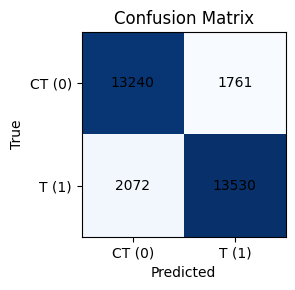

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Predições no teste
y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]  # prob. da classe "T" (1)

# Métrica simples
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}\n")

# Relatório por classe
print("Classification report:")
print(classification_report(y_test, y_pred, target_names=["CT (0)", "T (1)"]))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xticks([0,1], ["CT (0)","T (1)"])
plt.yticks([0,1], ["CT (0)","T (1)"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()


In [ ]:
import pandas as pd

# Gera novamente as predições
y_pred = pipe.predict(X_test)
y_proba_T = pipe.predict_proba(X_test)[:, 1]
y_proba_CT = 1 - y_proba_T

pred_df = pd.DataFrame({
    "row_id": y_test.index,     # índice original das linhas de teste
    "y_true": y_test.values,    # 0=CT, 1=T
    "y_pred": y_pred,           # classe prevista
    "proba_CT": y_proba_CT,     # prob. da classe 0 (CT)
    "proba_T": y_proba_T        # prob. da classe 1 (T)
})

pred_df.to_csv("/content/test_predictions.csv", index=False, encoding="utf-8")
print("Arquivo salvo em: /content/test_predictions.csv")
pred_df.head(10)


Arquivo salvo em: /content/test_predictions.csv


,row_id,y_true,y_pred,proba_CT,proba_T
0,104477,1,1,0.4575,0.5425
1,66010,1,1,0.0425,0.9575
2,42385,0,0,1.0000,0.0000
3,56057,0,0,0.9375,0.0625
4,34521,1,1,0.1650,0.8350
5,83424,1,1,0.0225,0.9775
6,15417,0,0,0.7050,0.2950
7,16477,0,0,0.8325,0.1675
8,84923,1,1,0.4075,0.5925
9,39962,0,0,0.7025,0.2975


Total de features pós-preprocessamento: 94
Selecionadas pelo SelectFromModel     : 47
Exemplos de selecionadas: ['num__time_left' 'num__ct_score' 'num__t_score' 'num__ct_health'
 'num__t_health' 'num__ct_money' 'num__t_money' 'num__ct_helmets'
 'num__t_helmets' 'num__ct_defuse_kits']


,feature,importance
5,num__ct_money,0.068221
6,num__t_money,0.068111
8,num__t_helmets,0.063476
0,num__time_left,0.048519
7,num__ct_helmets,0.042213
4,num__t_health,0.041971
3,num__ct_health,0.041329
9,num__ct_defuse_kits,0.038703
2,num__t_score,0.037965
1,num__ct_score,0.037659


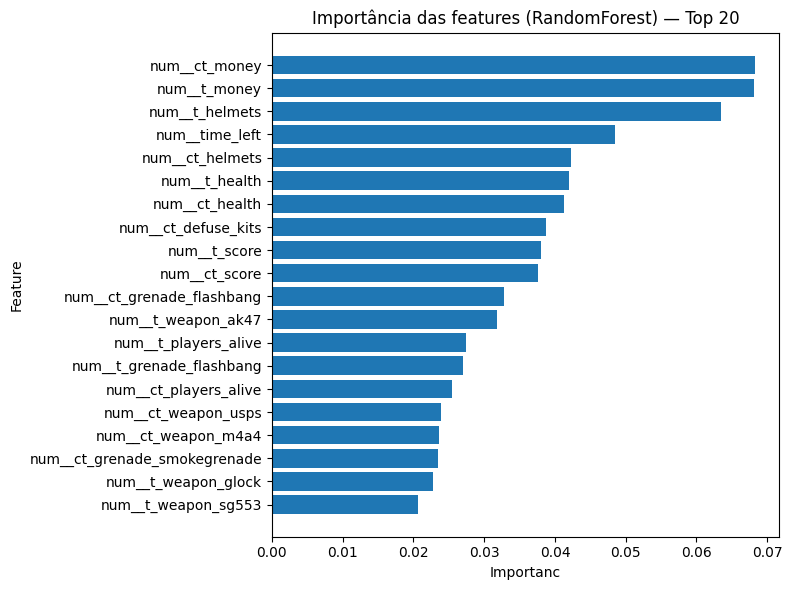

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 6.1) Quantas features existiam e quantas ficaram
pre = pipe.named_steps["pre"]
sel = pipe.named_steps["sel"]
clf = pipe.named_steps["clf"]

feat_names = pre.get_feature_names_out()
mask = sel.get_support()
selected_names = feat_names[mask]

print("Total de features pós-preprocessamento:", len(feat_names))
print("Selecionadas pelo SelectFromModel     :", int(mask.sum()))
print("Exemplos de selecionadas:", selected_names[:10])

# 6.2) Importância das features no classificador final
importances = getattr(clf, "feature_importances_", None)
assert importances is not None, "O classificador não fornece importances_."

imp_df = pd.DataFrame({
    "feature": selected_names,
    "importance": importances
}).sort_values("importance", ascending=False)

display(imp_df.head(20))

# 6.3) Gráfico (Top 20)
top = min(20, len(imp_df))
plt.figure(figsize=(8, 6))
plt.barh(imp_df.head(top)["feature"][::-1], imp_df.head(top)["importance"][::-1])
plt.title("Importância das features (RandomForest) — Top 20")
plt.xlabel("Importanc")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

# 75% treino / 25% teste, com estratificação para manter a proporção CT/T
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

print("Shapes:", X_train.shape, X_test.shape)
print("Proporção treino:", y_train.value_counts(normalize=True).round(3).to_dict())
print("Proporção teste :", y_test.value_counts(normalize=True).round(3).to_dict())


Shapes: (91807, 87) (30603, 87)
Proporção treino: {1: 0.51, 0: 0.49}
Proporção teste : {1: 0.51, 0: 0.49}


In [ ]:
## Resumo do pipeline (Parte I)

**Problema:** Classificação supervisionada para prever `round_winner` (CT=0, T=1).
**Split:** 75% treino / 25% teste (estratificado).
**Pré-processamento:**
- Numéricas → imputação por mediana.
- Categóricas → imputação por mais frequente + OneHotEncoder.

**Seleção de atributos (obrigatória):**
- Técnica: **SelectFromModel** com **ExtraTreesClassifier** (`threshold="median"`).
- O seletor treina **apenas no conjunto de treino** (dentro do `Pipeline`) e mantém ~50% das features mais importantes, **sem vazar informação** do teste.
- Resultado: **94** features pós-preprocessamento → **47** selecionadas.

**Modelo final:** RandomForestClassifier (n_estimators=400, random_state=42).
**Métricas (teste):** Accuracy ~ **0.875** (vide classification report e matriz de confusão acima).

**Principais features (exemplos):**
`time_left`, `ct_score`, `t_score`, `ct_health`, `t_health`, `ct_money`, `t_money`, `ct_helmets`, `t_helmets`, `ct_defuse_kits`, granadas e armas chave etc.

**Observações:**
- Árvores não exigem normalização; por isso **não** usei `StandardScaler`.
- (Opcional) poderíamos testar remoção de outliers e comparar.
- (Opcional) poderíamos trocar **seleção** por **extração** (ex.: PCA) na Parte II para comparar desempenho e interpretabilidade.

**Próximos passos (Parte II):**
- Tuning de hiperparâmetros (RandomizedSearchCV / GridSearchCV).
- Testar LightGBM/XGBoost.
- Curva de aprendizado; validação temporal por round/time_left; análise de erro por mapa / economia (money).
